In [181]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [135]:
sns.set_theme()

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [137]:
f"using device {device}"

'using device cpu'

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

In [3]:
batch_size = 4

In [13]:
data_dir = "../datasets/cifar-10-batches-py"
download_flag = not os.path.exists(data_dir)

In [17]:
train_dataset = torchvision.datasets.CIFAR10(
    root = "../datasets",
    train = True,
    transform = transform,
    download = download_flag
)

test_dataset = torchvision.datasets.CIFAR10(
    root = "../datasets",
    train = False,
    transform = transform,
    download = download_flag
)

In [18]:
train_dataset_size = 0.8
validation_dataset_size = 0.2

In [19]:
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_dataset_size, validation_dataset_size])

In [20]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

validation_loader = torch.utils.data.DataLoader(
    dataset = validation_dataset,
    batch_size = batch_size,
    shuffle = False
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [21]:
print(f"our training dataset has {len(train_loader)} batches and each batch contains {batch_size} images so total {len(train_loader) * batch_size} images in training dataset\nour validation dataset has {len(validation_loader)} batches and each batch contains {batch_size} images so total {len(validation_loader) * batch_size} images in validation dataset\nour test dataset has {len(test_loader)} batches and each batch contains {batch_size} images so total {len(test_loader) * batch_size} images in test dataset")

our training dataset has 10000 batches and each batch contains 4 images so total 40000 images in training dataset
our validation dataset has 2500 batches and each batch contains 4 images so total 10000 images in validation dataset
our test dataset has 2500 batches and each batch contains 4 images so total 10000 images in test dataset


In [106]:
def show_image(image, labels):
    image = image / 2 + 0.5  # unnormalize
    numpy_image = image.numpy()
    transposed_image = np.transpose(numpy_image, (1, 2, 0))  # for plotting purpose
    plt.axis("off")
    
    label_names = '        |        '.join(classes[label.item()] for label in labels)
    plt.title(label_names)

    plt.imshow(transposed_image)
    plt.show()

In [112]:
train_data_iter = iter(train_loader)

In [113]:
train_images_batch, train_labels_batch = next(train_data_iter)

In [114]:
train_images_batch.shape, train_labels_batch.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [115]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

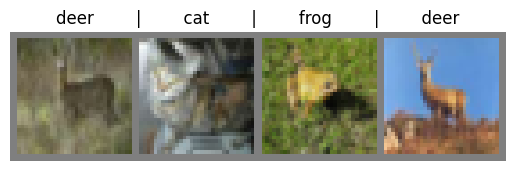

In [116]:
show_image(torchvision.utils.make_grid(train_images_batch), train_labels_batch)

- out_channels parameter in the Conv2d layer is a hyper-paramater and so the kernel_size is
- the number of output channels of the first convolutional layer will be the input of the second convolutional layer and so on
- the output of the convolutional layer will be calculated like this: [out_channels, image_width, image_height] = [in_channels, image_width - kernel_size + 1, image_height - kernel_size + 1]
- pooling layer halves the width and height of the image
- ReLU activation function is applied on the convoluated output and then the pooling layer is applied on that activated output

In [124]:
def plot_metrics(train_accuracies, train_losses, val_accuracies, val_losses):
    epochs = range(1, len(train_accuracies) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    axes[0].plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='green')
    axes[0].plot(epochs, train_losses, label='Training Loss', marker='x', color='red')
    axes[0].set_title('Training Accuracy and Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Value')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
    axes[1].plot(epochs, val_losses, label='Validation Loss', marker='x', color='red')
    axes[1].set_title('Validation Accuracy and Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Value')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [125]:
class EarlyStopping:
    def __init__(self, patience = 3, min_delta = 0.0, path = "best_model.pt", verbose = True):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"\nEarlystopping counter: {self.counter}/{self.patience}")
            if self.counter == self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        if self.verbose:
            print(f"\nValidation loss improved than before. Saving model to {self.path}")
        torch.save(model.state_dict(), self.path)

In [164]:
def train(model, epochs, train_loader, val_loader, optimizer, criterion, early_stopper, device):
    print("Training started")
    
    training_starting_time = time.time()

    training_accuracies, training_losses, validation_accuracies, validation_losses = [], [], [], []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_starting_time = time.time()
        
        print(f"\nEpoch # {epoch}\n")
        
        epoch_total_training_loss, epoch_training_predictions, epoch_training_labels = 0., [], []
        epoch_total_validation_loss, epoch_validation_predictions, epoch_validation_labels = 0., [], []
        
        for batch_no, (training_inputs_batch, training_labels_batch) in enumerate(train_loader):
            training_inputs_batch, training_labels_batch = training_inputs_batch.to(device), training_labels_batch.to(device)
            
            optimizer.zero_grad()
            
            training_outputs = model(training_inputs_batch)
            
            batch_training_loss = criterion(training_outputs, training_labels_batch)
    
            epoch_total_training_loss += batch_training_loss.item()
    
            batch_training_loss.backward()
    
            optimizer.step()
            
            _, training_predictions = torch.max(training_outputs.data, 1)
    
            epoch_training_predictions.extend(training_predictions)
            epoch_training_labels.extend(training_labels_batch)
    
            if (batch_no + 1) % 1000 == 0:
                    print(f"Batch # {batch_no + 1} / {len(train_loader)}, Loss: {batch_training_loss:.3f}")
    
        model.eval()
        
        with torch.no_grad():
            for validation_inputs_batch, validation_labels_batch in val_loader:
                validation_inputs_batch, validation_labels_batch = validation_inputs_batch.to(device), validation_labels_batch.to(device)
                
                validation_outputs = model(validation_inputs_batch)
                
                batch_validation_loss = criterion(validation_outputs, validation_labels_batch)
        
                epoch_total_validation_loss += batch_validation_loss.item()
                
                _, validation_predictions = torch.max(validation_outputs.data, 1)
        
                epoch_validation_predictions.extend(validation_predictions)
                epoch_validation_labels.extend(validation_labels_batch)
    
        training_accuracy = ((torch.tensor(epoch_training_predictions) == torch.tensor(epoch_training_labels)).sum().item()) / len(epoch_training_labels)
        training_loss = epoch_total_training_loss / len(train_loader)
        
        validation_accuracy = ((torch.tensor(epoch_validation_predictions) == torch.tensor(epoch_validation_labels)).sum().item()) / len(epoch_validation_labels)
        validation_loss = epoch_total_validation_loss / len(val_loader)
    
        training_accuracies.append(training_accuracy)
        training_losses.append(training_loss)
        
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(validation_loss)

        early_stopper(validation_loss, model)

        if early_stopper.early_stop:
            print(f"\nEarly stopping triggered, Training stopped because validation loss was increasing instead of decreasing.\n")
            break
    
        print(f"\nTraining Accuracy: {training_accuracy:.3f}, Training Loss: {training_loss:.3f}, Validation Accuracy: {validation_accuracy:.3f}, Validation Loss: {validation_loss:.3f}")

        print(f"\nEpoch Duration: {int(time.time() - epoch_starting_time)} seconds")

    training_ending_time = time.time()

    training_elapsed_time = training_ending_time - training_starting_time

    training_elapsed_time_minutes = training_elapsed_time // 60

    print(f"Training completed in {int(training_elapsed_time_minutes)} minutes and {int(training_elapsed_time - (training_elapsed_time_minutes * 60))} seconds")
    
    print(f"\nTraining ended")

    return training_accuracies, training_losses, validation_accuracies, validation_losses

In [165]:
criterion = nn.CrossEntropyLoss()

In [166]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5) # after applying conv1 on [3, 32, 32] -> [8, 32 - 5 + 1, 32 - 5 + 1] -> [8, 28, 28]
        self.pool = nn.MaxPool2d(2, 2) # pooling halves height and width so [8, 28, 28] -> [8, 14, 14]
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5) # after applying conv2 on [8, 14, 14] -> [16, 14 - 5 + 1, 14 - 5 + 1] -> [16, 10, 10] and after pooling this we get [16, 5, 5]
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [170]:
epochs = 5

In [173]:
cnn = CNN().to(device)
optimizer = torch.optim.AdamW(cnn.parameters(), lr = 1e-3)
early_stopper = EarlyStopping(patience = 3, path = "../trained models/cifar-10_cnn.pt")

In [174]:
training_accuracies, training_losses, validation_accuracies, validation_losses = train(cnn, epochs, train_loader, validation_loader, optimizer, criterion, early_stopper, device)

Training started

Epoch # 1

Batch # 1000 / 10000, Loss: 1.429
Batch # 2000 / 10000, Loss: 1.005
Batch # 3000 / 10000, Loss: 1.421
Batch # 4000 / 10000, Loss: 1.856
Batch # 5000 / 10000, Loss: 0.544
Batch # 6000 / 10000, Loss: 1.531
Batch # 7000 / 10000, Loss: 2.279
Batch # 8000 / 10000, Loss: 1.183
Batch # 9000 / 10000, Loss: 0.934
Batch # 10000 / 10000, Loss: 1.865

Validation loss improved than before. Saving model to ../trained models/cifar-10_cnn.pt

Training Accuracy: 0.418, Training Loss: 1.587, Validation Accuracy: 0.500, Validation Loss: 1.374

Epoch Duration: 90 seconds

Epoch # 2

Batch # 1000 / 10000, Loss: 1.375
Batch # 2000 / 10000, Loss: 1.249
Batch # 3000 / 10000, Loss: 1.285
Batch # 4000 / 10000, Loss: 1.191
Batch # 5000 / 10000, Loss: 1.496
Batch # 6000 / 10000, Loss: 0.475
Batch # 7000 / 10000, Loss: 0.877
Batch # 8000 / 10000, Loss: 1.198
Batch # 9000 / 10000, Loss: 1.250
Batch # 10000 / 10000, Loss: 1.072

Validation loss improved than before. Saving model to ../tr

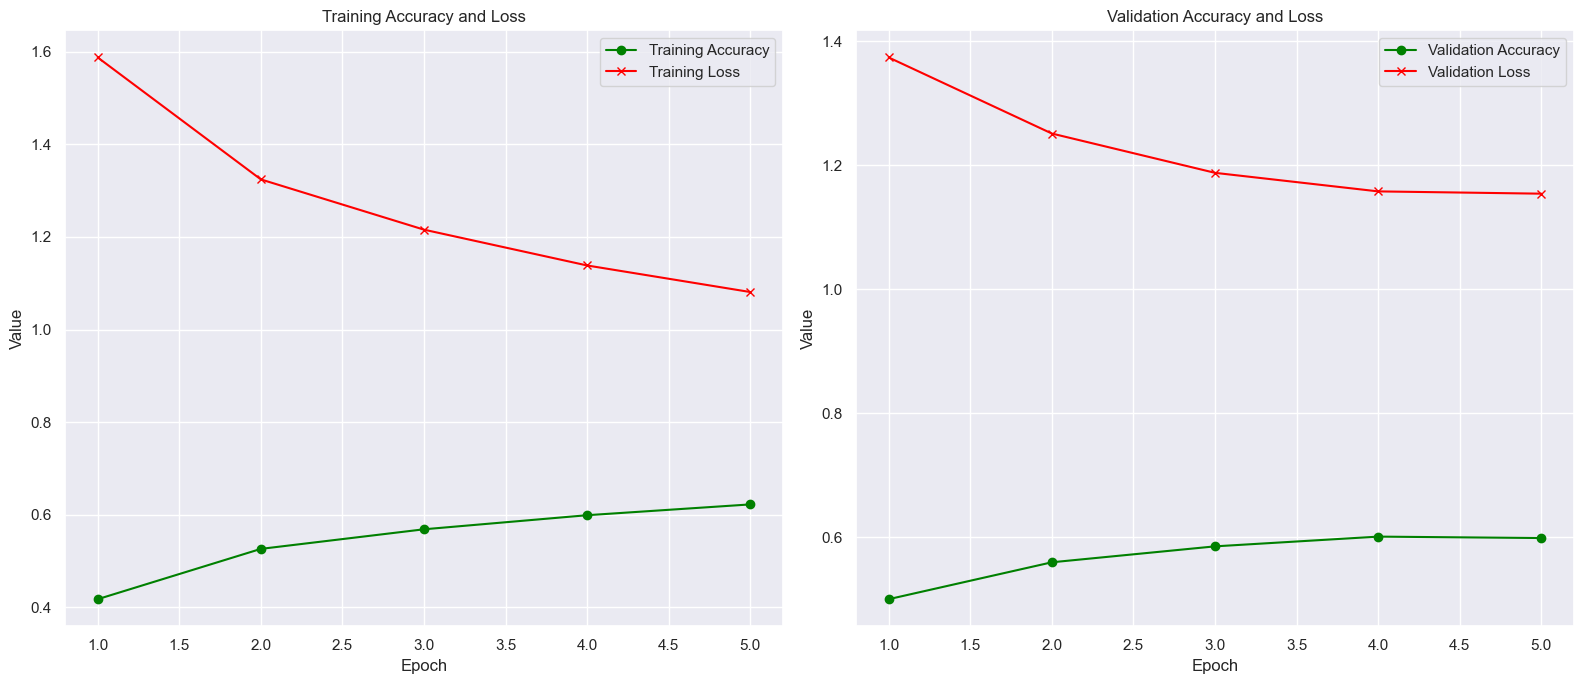

In [175]:
plot_metrics(training_accuracies, training_losses, validation_accuracies, validation_losses)

In [178]:
def evaluation(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [179]:
cnn.load_state_dict(torch.load("../trained models/cifar-10_cnn.pt"))

<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

       plane       0.54      0.73      0.62      1000
         car       0.76      0.70      0.73      1000
        bird       0.53      0.46      0.49      1000
         cat       0.45      0.32      0.37      1000
        deer       0.51      0.58      0.54      1000
         dog       0.47      0.54      0.50      1000
        frog       0.81      0.57      0.67      1000
       horse       0.70      0.60      0.65      1000
        ship       0.59      0.81      0.69      1000
       truck       0.67      0.64      0.65      1000

    accuracy                           0.59     10000
   macro avg       0.60      0.59      0.59     10000
weighted avg       0.60      0.59      0.59     10000



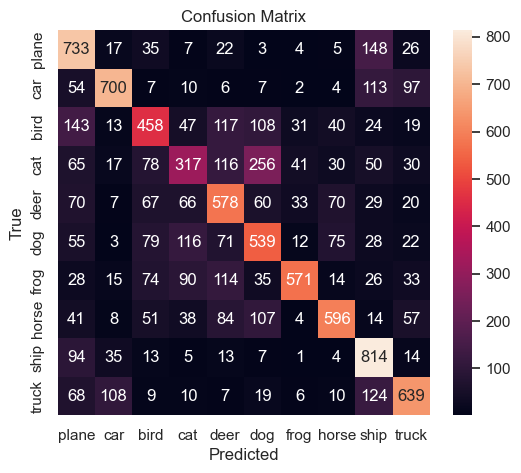

In [182]:
evaluation(cnn, test_loader, device)

I got an accuracy of 59% because I don't have a GPU, and each epoch was taking around 1 to 2 minutes to train. I only trained the model for 5 epochs, but I'm confident that I can achieve better accuracy if I train it for 30 to 40 epochs.